# Financial Data Scraping

## Project Overview
This project aims to scrape financial data of Lithuanian IT companies from the website rekvizitai.lt.
The website contains information about various companies, including their financial reports.
We will extract the names of IT companies from the website and create a DataFrame to store the data.

### 1. Acquiring Company Names
The initial step of this project involves the acquisition of company names from the rekvizitai.lt website. The primary objective is to gather a comprehensive list of Lithuanian IT companies. By obtaining this essential information, we pave the way for further exploration and analysis of their financial data.

In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

base_url = 'https://rekvizitai.vz.lt/imones/kompiuteriu_programines_irangos_kurimas/'

# Create an empty list to store the company names
company_names = []

# Loop through pages 1 to 222
for page_number in range(1, 223):
    url = f'{base_url}{page_number}/'

    # Send an HTTP request to the page
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all the links on the page
        links = soup.find_all('a')

        # Extract the company names from the links and add them to the list
        for link in links:
            href = link.get('href')
            if href is not None and href.startswith('https://rekvizitai.vz.lt/imone/'):
                company_name = href.replace('https://rekvizitai.vz.lt/imone/', '').rstrip('/')
                if not company_name.endswith('/atsiliepimai'):
                    company_names.append(company_name)

    else:
        print(f'Failed to fetch the page. Status code: {response.status_code}')

# Create a DataFrame from the list of company names
df = pd.DataFrame(company_names, columns=['Company'])

# Remove duplicates from the DataFrame
df.drop_duplicates(inplace=True)

# Print the DataFrame
print(df)

                        Company
0                auriga_baltics
4     edrana_a_lukosienes_imone
8             czar_intelligence
12                       rivile
16                       ilotus
...                         ...
1810                   kirotech
1814                   komvista
1818               uab_linditex
1822                   liubitas
1826           midpoint_systems

[335 rows x 1 columns]


### 2. Acquiring and Mergin the Financial Data
Having successfully acquired the list of Lithuanian IT company names, the next crucial step of the project involves gathering the final financial data from each of these companies. To achieve this, we employ web scraping techniques once again, this time focusing on individual pages dedicated to each company's financial information.

In [37]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

# Load the DataFrame with company names from the provided script
# Replace "company_names.csv" with the actual filename or path if needed


# Create an empty list to store all the data from different companies
all_data_list = []

# Loop through each company to visit their individual pages and extract data
for index, row in df.iterrows():
    # Construct the URL for the company's financial data page
    company_url = f"https://rekvizitai.vz.lt/imone/{row['Company']}/apyvarta/"

    # Send a request to fetch the company's page content
    response = requests.get(company_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the company's page
        soup = BeautifulSoup(response.content, "html.parser")

        # Find the table element on the company's page (you may need to inspect the page's HTML to find the correct table)
        table = soup.find("table")

        # Check if the table was found
        if table:
            # Get the table rows
            rows = table.find_all("tr")

            # Get the header columns (column names) from the first row
            header_row = rows[0]
            headers = header_row.find_all("th")
            headers = [header.text.strip() for header in headers]

            # Loop through the remaining rows and extract the data
            for data_row in rows[1:]:
                # Get the columns in each row
                cols = data_row.find_all("td")

                # Extract the data from each column and store it in a dictionary
                data_dict = {}
                if cols:
                    for i, header in enumerate(headers):
                        data_dict[header] = cols[i].text.strip()
                    data_dict['Company'] = row['Company']  # Add company name to data_dict
                    all_data_list.append(data_dict)
        else:
            print(f"Table not found for {row['Company']}.")
    else:
        print(f"Failed to fetch the web page for {row['Company']}. Status code:", response.status_code)

# Create a pandas DataFrame from the list of dictionaries for all companies
result_df = pd.DataFrame(all_data_list)

# Print the DataFrame
print(result_df)

                                    Metai         2018         2019  \
0                       Ilgalaikis turtas     84 225 €     96 821 €   
1                     Trumpalaikis turtas    206 273 €    396 870 €   
2                      Nuosavas kapitalas     89 837 €    117 023 €   
3      Mokėtinos sumos ir įsipareigojimai    207 732 €    384 641 €   
4                       Pardavimo pajamos  2 120 944 €  2 864 857 €   
...                                   ...          ...          ...   
2914                    Pardavimo pajamos    455 493 €    553 047 €   
2915  Pelnas (nuostoliai) prieš mokesčius     27 030 €     -2 733 €   
2916          Pelningumas prieš mokesčius       5,93 %      -0,49 %   
2917         Grynasis pelnas (nuostoliai)     25 773 €     -2 733 €   
2918                 Grynasis pelningumas       5,66 %      -0,49 %   

             2020         2021         2022           Company 2017 2016 2023  \
0       115 585 €    200 122 €    185 397 €    auriga_baltics  NaN 

In [94]:
df_unpivot = pd.melt(result_df, id_vars=['Company', 'Metai'], value_vars=['2014',
                                                                          '2015',
                                                                          '2016',
                                                                          '2017',
                                                                          '2018',
                                                                          '2019',
                                                                          '2020',
                                                                          '2021',
                                                                          '2022'
                                                                          ])
# Rename the columns for clarity
df_unpivot.rename(columns={
    'Company': 'company',
    'Metai': 'financial_line',
    'variable': 'year',
    'value': 'financial_result'
}, inplace=True)

df_unpivot.head()

,company,financial_line,year,financial_result
0,auriga_baltics,Ilgalaikis turtas,2014,NaN
1,auriga_baltics,Trumpalaikis turtas,2014,NaN
2,auriga_baltics,Nuosavas kapitalas,2014,NaN
3,auriga_baltics,Mokėtinos sumos ir įsipareigojimai,2014,NaN
4,auriga_baltics,Pardavimo pajamos,2014,NaN


### 3. Visualizing the Data
The last step of this analysis is to visualize the gathered data

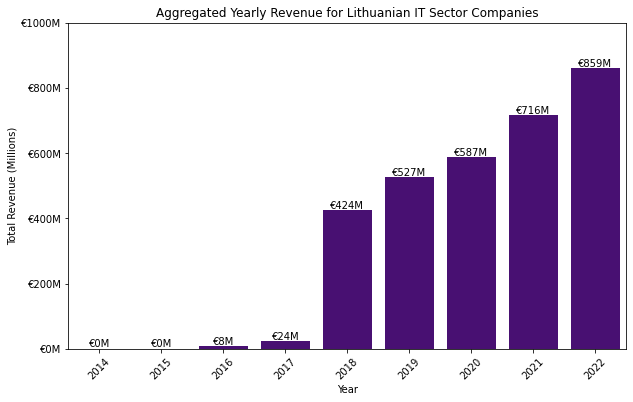

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the df_unpivot DataFrame is already created with the given data
# Convert the 'financial_result' column to numeric data type after replacing empty strings with NaN
df_unpivot['financial_result'] = pd.to_numeric(df_unpivot['financial_result'].str.replace('[^\d.]', '', regex=True), errors='coerce')

# Filter the data for the 'Pardavimo pajamos' financial_line
pardavimo_pajamos_data = df_unpivot[df_unpivot['financial_line'] == 'Pardavimo pajamos']

# Group the data by year and calculate the sum of 'financial_result'
grouped_data = pardavimo_pajamos_data.groupby('year')['financial_result'].sum()

# Plot the aggregated yearly bar chart using Seaborn with specific settings
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_data.index, y=grouped_data.values, color='indigo')
plt.title("Aggregated Yearly Revenue for Lithuanian IT Sector Companies")
plt.xlabel("Year")
plt.ylabel("Total Revenue (Millions)")
plt.xticks(rotation=45)

# Set y-axis limit to 1000 million
plt.ylim(0, 1000e6)

# Format y-axis tick labels to display values in millions
plt.gca().yaxis.set_major_formatter(lambda x, _: f'€{x/1e6:.0f}M')

# Display the values on top of each bar with proper formatting
for index, value in enumerate(grouped_data.values):
    plt.text(index, value, f'€{value/1e6:.0f}M', ha='center', va='bottom')

plt.grid(True, which='both', linestyle='', linewidth=0.5)

plt.show()


## Conclusions
The project allows to quickly see the financial results in Lithuanian market. Similar logic could be applied to other sectors as well